In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import ta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as lyrs
from tensorflow.python.keras import backend as k

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from tensorflow.keras.models import Sequential, load_model

import math, time #helper libraries
import datetime

import itertools
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt

Using TensorFlow backend.


# Helper functions

In [9]:
## adapted from: 
## https://github.com/etai83/lstm_stock_prediction/blob/master/.ipynb_checkpoints/GOOGLE%20stock%20prediction-checkpoint.ipynb

def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [59]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = tf.keras.Sequential()
        model.add(lyrs.LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(lyrs.Dropout(d))
        model.add(lyrs.LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(lyrs.Dropout(d))
        model.add(lyrs.Dense(16,activation='tanh')) #kernel_initializer='uniform'        
        model.add(lyrs.Dense(1,activation='tanh')) #kernel_initializer='uniform'
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

# Data manipulation and Learning

In [96]:
data = yf.download('GOOGL','2013-07-12','2017-07-11')



data['High'] = data['High'] #/ 1000
data['Open'] = data['Open'] #/ 1000
data['Close'] = data['Close'] #/ 1000


data = data.reset_index()

data=data.drop(['Date'], axis = 1)

data.drop(data.columns[[2,4,5]], axis=1, inplace=True) 

data.head()



[*********************100%***********************]  1 of 1 completed


,Open,High,Close
0,460.460449,461.961975,461.961975
1,462.612610,464.464478,462.807800
2,464.029022,464.449463,460.265259
3,460.960968,463.893890,459.734741
4,459.954956,460.460449,455.795807


In [78]:
window = 5
X_train, y_train, X_test, y_test = load_data(data, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (901, 5, 3)
y_train (901,)
X_test (100, 5, 3)
y_test (100,)


/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [79]:
model = build_model2([3,window,1])
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.41 MSE (0.64 RMSE)
Test Score: 0.81 MSE (0.90 RMSE)


In [94]:
diff=[]
ratio=[]
p = model.predict(X_test) *100 +.02
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

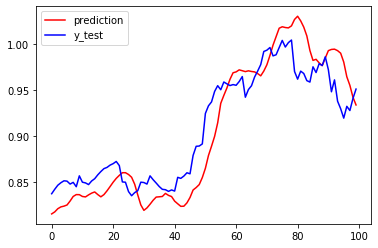

In [95]:
import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()